In [1]:
!pip install -q japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read data
restaurantDfRaw = pd.read_csv('/content/drive/MyDrive/data/restaurant.csv')

# only"好き" and drop categorical variables
restaurantDf = restaurantDfRaw[restaurantDfRaw['好き']==1].drop(['好き','料理区分','店名'],axis=1)

# normalization
restaurantDfNorm = MinMaxScaler().fit_transform(restaurantDf)
restaurantDfNorm = pd.DataFrame(restaurantDfNorm ,columns = restaurantDf.columns)

## K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='Cluster'>

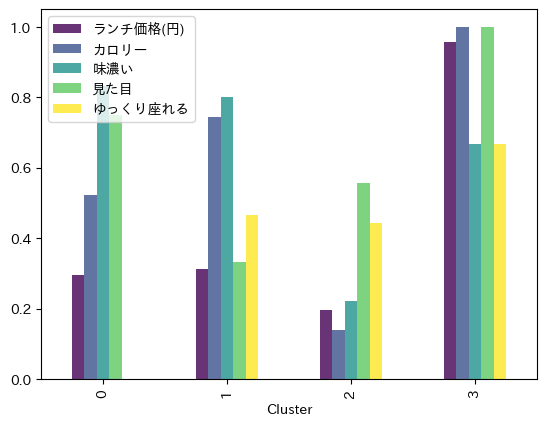

In [55]:
# k = 4
cluster = KMeans(n_clusters=4,random_state=0).fit(restaurantDfNorm)
restaurantDfNorm['Cluster'] = cluster.labels_

# avgs bar chart grouped by clusters
restaurantCluster = restaurantDfNorm.groupby('Cluster').mean()
restaurantCluster.plot(kind='bar',colormap='viridis',alpha=0.8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

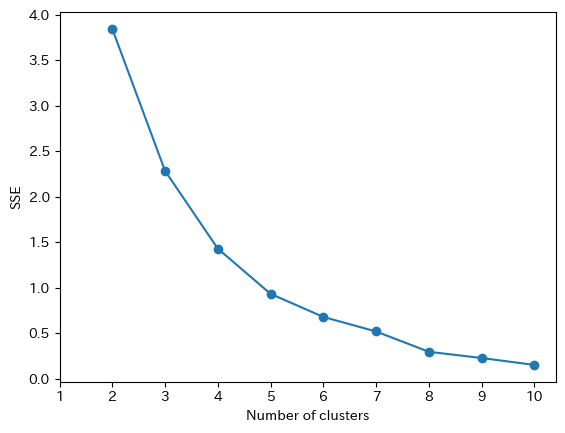

In [56]:
# Elbow Method
SSE=[]
for i in range(2,11):
  model = KMeans(n_clusters=i,random_state=0).fit(restaurantDfNorm.drop('Cluster',axis=1))
  SSE.append(model.inertia_)

plt.plot(range(2,11), SSE, marker='o')
plt.xticks(np.arange(1,11,1))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [58]:
# check items in clusters
restaurantLikeDf = restaurantDfRaw[restaurantDfRaw['好き']==1]
nameMap = {}
for i in range(len(restaurantLikeDf)):
  nameMap[i] = restaurantLikeDf['店名'].values[i]

k = 4
for i in range(0, k):
  d = restaurantDfNorm[restaurantDfNorm['Cluster'] == i]
  print(f'クラスタ{i}のアイテム: {[nameMap[j] for j in list(d.index)]}')

クラスタ0のアイテム:['どんぴしゃり', '武蔵野あぶら学会', '渡なべ', 'らぁ麺やまぐち']
クラスタ1のアイテム:['麺屋こころ', 'ティーヌン', '末廣ラーメン本舗', '揚げ太郎', 'レッドロック']
クラスタ2のアイテム:['subway', '蔭山', 'うどん蔵之介']
クラスタ3のアイテム:['肉ドレス酒場', 'とんかつ ひなた']


## AutoEncoder

In [59]:
import torch
import torch.nn as nn

# fix seed
torch.manual_seed(0)

In [60]:
# transform to tensor
restaurantTensor = torch.Tensor(restaurantDfNorm.drop(['Cluster'],axis=1).values).float()

# define unit nums
inputDim = restaurantTensor.shape[1]
hiddenDim1 = 4
hiddenDim2 = 2

# define autoencoder
class Autoencoder(nn.Module):
    def __init__(self, inputDim, hiddenDim1, hiddenDim2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
              nn.Linear(inputDim, hiddenDim1),
              nn.ReLU(inplace=True),
              nn.Linear(hiddenDim1,hiddenDim2))
        self.Sigmoid = nn.Sigmoid()
        self.decoder = nn.Sequential(
              nn.Linear(hiddenDim2, hiddenDim1),
              nn.ReLU(inplace=True),
              nn.Linear(hiddenDim1,inputDim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.Sigmoid(x)
        x = self.decoder(x)
        return x

model = Autoencoder(inputDim, hiddenDim1, hiddenDim2)

In [61]:
# loss func and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# start learning
for epoch in range(10000):
    pred = model(restaurantTensor)
    loss = criterion(pred, restaurantTensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.29999151825904846
Epoch: 1000, Loss: 0.09167692810297012
Epoch: 2000, Loss: 0.09167692810297012
Epoch: 3000, Loss: 0.09167692810297012
Epoch: 4000, Loss: 0.09167693555355072
Epoch: 5000, Loss: 0.09167692810297012
Epoch: 6000, Loss: 0.09167692810297012
Epoch: 7000, Loss: 0.09167692810297012
Epoch: 8000, Loss: 0.09167692810297012
Epoch: 9000, Loss: 0.09167693555355072


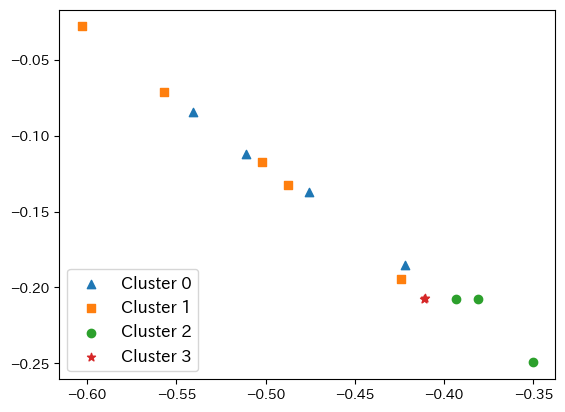

In [62]:
# get dimensionality reduction data
encodedData = model.encoder(restaurantTensor).detach().numpy()

# plot data
markers = ['^', 's', 'o', '*']
for i in range(4):
    clusterData = encodedData[restaurantDfNorm['Cluster'] == i]
    plt.scatter(clusterData[:, 0], clusterData[:, 1],
                label=f'Cluster {i}', marker=markers[i])
plt.legend(fontsize=12, loc ='lower left')
plt.show()

## Association Analysis

In [63]:
!pip install -q mlxtend | tail -n 1
from mlxtend.frequent_patterns import apriori, association_rules

In [80]:
#データの成形
restaurantDfDum = restaurantDfRaw.drop(['店名'],axis=1).astype(str)
restaurantDfDum = pd.get_dummies(restaurantDfDum)

In [93]:
# aprioriでsupportが0.2より高い特徴とその組み合わせを抽出
restaurantRule = apriori(restaurantDfDum, min_support=0.2, max_len=4, use_colnames=True)

# confidenceが0.6よりも高い組み合わせを抽出
restaurantRule = association_rules(restaurantRule, metric='confidence', min_threshold=0.6)

# 帰結部が"好き_1"(好き)である組み合わせを抽出
restaurantRule[restaurantRule['consequents']=={'好き_1'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(味濃い_3),(好き_1),0.423077,0.538462,0.269231,0.636364,1.181818,0.041420,1.269231
6,(見た目_4),(好き_1),0.307692,0.538462,0.230769,0.750000,1.392857,0.065089,1.846154
7,(ゆっくり座れる_1),(好き_1),0.384615,0.538462,0.230769,0.600000,1.114286,0.023669,1.153846


In [92]:
# aprioriでsupportが0.15より高い特徴とその組み合わせを選出
restaurantRule = apriori(restaurantDfDum, min_support=0.15,max_len=3,use_colnames=True)

# liftが1よりも高い組み合わせを選出
restaurantRule = association_rules(restaurantRule, metric='lift',min_threshold=1)

# 帰結部が"好き_0"(好きではない)の組み合わせを抽出
restaurantRule[restaurantRule['consequents']=={'好き_0'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
25,(味濃い_4),(好き_0),0.346154,0.461538,0.192308,0.555556,1.203704,0.032544,1.211538
27,(見た目_2),(好き_0),0.192308,0.461538,0.153846,0.800000,1.733333,0.065089,2.692308
29,(見た目_3),(好き_0),0.307692,0.461538,0.153846,0.500000,1.083333,0.011834,1.076923
